# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](http://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

#### Documentation
1. [CIFAR10](http://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html)
2. [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html)

In [3]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Define transforms, Resize not necessary since image size is small, but included anyway
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

# Create training set and define training dataloader
trainset = CIFAR10(root='./', train=True, transform=train_transform, download=True)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
testset = CIFAR10(root='./', train=False, transform=test_transform, download=True)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
labels = np.array([])
dataiter = iter(trainloader)
for images, label in dataiter:
    labels = np.concatenate((labels, label))
    
labels = labels.astype(int)

### Distribution of dataset
- Our dataset is seen to be equally distributed among all ur labels
- Typically we would need to consider further sampling techniques if our distribution is skewed

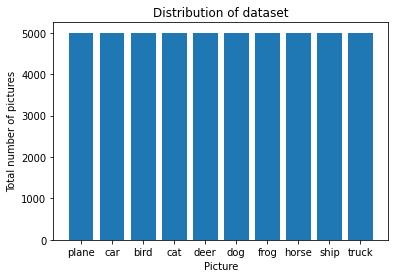

In [5]:
plt.bar(classes, pd.Series(labels).value_counts())
plt.title('Distribution of dataset')
plt.xlabel('Picture')
plt.ylabel('Total number of pictures')
plt.show()

In [6]:
from torchvision.utils import make_grid

def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        # Need to permute images from (3, 32, 32) to (32, 32, 3)
        # can also use image.permute(1, 2, 0)
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()
        
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

#### Exploring training data

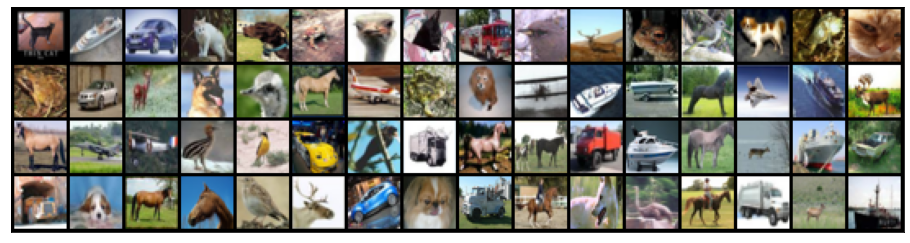

In [7]:
# Explore data
show_batch(trainloader)

#### Exploaring test data

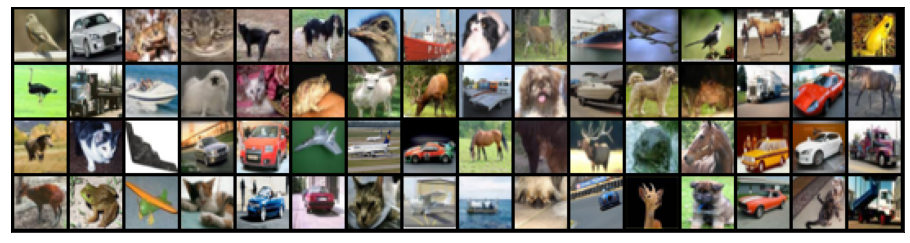

In [8]:
show_batch(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [52]:
case_num = 'Case_13'

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 3 = RGB, 5 = 5x5, 6 = 6 output layers 
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        # batch norm (according to depth of previous layer)
        # - https://discuss.pytorch.org/t/example-on-how-to-use-batch-norm/216
        self.conv_bn1 = nn.BatchNorm2d(32)
        # input channel size must equal to last output channel size
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv_bn2 = nn.BatchNorm2d(32)
        # how does pooling work
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv_bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv_bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        # fully connected layer
        self.fc1 = nn.Linear(64 * 8 * 8, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 84)
        self.fc5 = nn.Linear(84, 10)
        # dropout - https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        self.dropout3 = nn.Dropout(p=0.5)
        self.dropout4 = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = F.relu(self.conv_bn1(self.conv1(x)))
        x = self.pool1(F.relu(self.conv_bn2(self.conv2(x))))
        x = self.dropout1(x)
        x = F.relu(self.conv_bn3(self.conv3(x)))
        x = self.pool2(F.relu(self.conv_bn4(self.conv4(x))))
        x = self.dropout2(x)
        # flatten
        # pytorch will automatically define size, i.e. batches in this case
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout3(F.relu(self.fc1(x)))
        x = self.dropout4(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        # may not need softmax here in case it may have been included in our loss func
        x = self.fc5(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvNet()
model.to(device)

# Since not using nn.NLLoss(), no need to change output layer to log softmax 
criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [72]:
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [ ]:
# Load model trained earlier
state_dict = torch.load('Case_13d.pth')
model.load_state_dict(state_dict)

In [56]:
'''
Reinitialise images with normalization
Following from pytorch forum discussion over optimum optimisation amount
https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/6
'''
# Re-Define transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Create training set and define training dataloader
trainset = CIFAR10(root='./', train=True, transform=train_transform, download=True)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
testset = CIFAR10(root='./', train=False, transform=test_transform, download=True)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [54]:
'''
Returns mean of correct labels per batch
'''
def topk1_correct(res, labels):
    top_p, top_class = res.topk(1, dim=1)
    correct = top_class.view(res.shape[0]) == labels
    return torch.mean(correct.float()).item()

In [73]:
## YOUR CODE HERE ##
epochs = 50
train_loss_lst = []
test_loss_lst = []
test_acc_lst = []

for x in range(epochs):
    training_loss = 0
    for i, (images, labels) in enumerate(trainloader):
        # shift to gpu if available
        images, labels = images.to(device), labels.to(device)
        # reset optimizer to make sure gradients not accumulated
        optimizer.zero_grad()
        # obtain model res, calc batch loss and update training loss
        res = model(images)
        batch_loss = criterion(res, labels)
        training_loss += batch_loss.item()
        # backpropogation, and update model parameters
        batch_loss.backward()
        optimizer.step()
        
#         if i % 10 == 0:
#             print(".", end='')
        
    # model validation
    with torch.no_grad():
        # turn off dropout
        model.eval()
        test_loss = 0
        correct = 0
        for j, (images, labels) in enumerate(testloader):
            # shift to gpu if available
            images, labels = images.to(device), labels.to(device)
            # obtain model res, calc batch loss and update test loss
            res = model(images)
            batch_loss = criterion(res, labels)
            test_loss += batch_loss.item()
            correct += topk1_correct(res, labels)
    # turn on dropout
    model.train()
    
    # divide by len(trainloder), i.e. number of batches
    train_l = training_loss/len(trainloader)
    test_l = test_loss/len(testloader)
    test_a = correct/len(testloader)
    train_loss_lst.append(train_l)
    test_loss_lst.append(test_l)
    test_acc_lst.append(test_a)
    print(f'Epoch {x+1}/{epochs}. ' , end='')
    print(f'Avg train loss over dataset: {round(train_l, 4)}. ', end='')
    print(f'Avg test loss over dataset: {round(test_l, 4)}. ', end='')
    print(f'Acc over test set : {round(test_a, 4)}')

Epoch 1/50. Avg train loss over dataset: 0.4291. Avg test loss over dataset: 0.4198. Acc over test set : 0.8632
Epoch 2/50. Avg train loss over dataset: 0.4304. Avg test loss over dataset: 0.42. Acc over test set : 0.8627
Epoch 3/50. Avg train loss over dataset: 0.4292. Avg test loss over dataset: 0.4256. Acc over test set : 0.8608
Epoch 4/50. Avg train loss over dataset: 0.4204. Avg test loss over dataset: 0.4184. Acc over test set : 0.8612
Epoch 5/50. Avg train loss over dataset: 0.4222. Avg test loss over dataset: 0.4223. Acc over test set : 0.8616
Epoch 6/50. Avg train loss over dataset: 0.4226. Avg test loss over dataset: 0.4209. Acc over test set : 0.8625
Epoch 7/50. Avg train loss over dataset: 0.4223. Avg test loss over dataset: 0.4177. Acc over test set : 0.8631
Epoch 8/50. Avg train loss over dataset: 0.4276. Avg test loss over dataset: 0.4265. Acc over test set : 0.8626
Epoch 9/50. Avg train loss over dataset: 0.4219. Avg test loss over dataset: 0.4206. Acc over test set : 0

Plot the training loss (and validation loss/accuracy, if recorded).

In [18]:
def viz_performance(train_loss_lst, test_loss_lst, test_acc_lst, num_show, case, ylimset=False):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title(f'Training and test losses for {case}')
    plt.xlabel('n Epochs')
    plt.ylabel('Losses')
    if ylimset:
        plt.ylim(0)
    plt.plot(list(range(1, num_show + 1)), train_loss_lst[:num_show], label='Train loss')
    plt.plot(list(range(1, num_show + 1)), test_loss_lst[:num_show], label='Test loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title(f'Test set accuracy for {case}')
    plt.xlabel('n Epochs')
    plt.ylabel('Accuracy')
    if ylimset:
        plt.ylim(0)
    plt.plot(list(range(1, num_show + 1)), test_acc_lst[:num_show], label='Train loss')
    plt.legend()
    plt.show()

### Observation
- Training and testing losses are pretty congruent with each other, which suggest that there is low bias and variance
- The following tweaks has been made to our images and model throughout this project
    * Case 1 - 63.24% - Basic Convolutional Neural Network (CNN)
    * Case 2 - 68.80% - Included **additional Conv Nets**
    * Case 3 - 71.57% - **Added dropout** to hidden Dense layers
    * Case 4 - 73.13% - Reduced complexity of model, and **reduced learning rate**
    * Case 5 - 75.47% - **Increased additional Dense** and Conv nets, removed dropout
    * Case 6 - 71.57% - Reduced model complexity, added dropout
    * Case 7 - 78.84% - Increase model complexity, added dropout
    * Case 8 - 76.81% - Attempted **lower dropout rate**
    * Case 9 - 80.34% - Implemented **batch normalization**
    * Case 10 - 80.05% - Changes made over **Image Augmentation**
    * Case 11 - 80.13% - Somewhat improved Image Augmentation
    * Case 12 - 81.72% - **Tweaking model configuration** and Image Augmentation
    * Case 13 - 86.46% - Drastically increased epochs, decreased learning rate, added dropout and additional batch normalization for Conv nets

In [79]:
a = pd.read_csv('case_13a.csv')
b = pd.read_csv('case_13b.csv')
c = pd.read_csv('case_13c.csv')
d = pd.read_csv('case_13d.csv')
updated = a.append(b).append(c).append(d)
updated.index = list(range(1, 301))

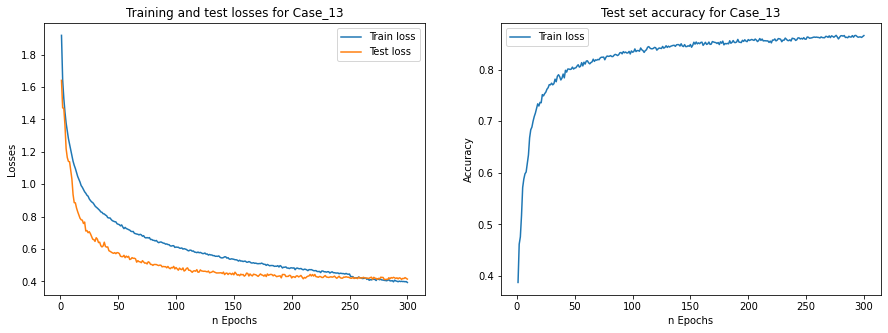

In [90]:
viz_performance(updated['train_loss'], updated['test_loss'], updated['test_acc'], updated.shape[0], 'Case_13')

In [59]:
def save_loss_data(train_loss_lst, test_loss_lst, test_acc_lst, title):
    df = pd.DataFrame({
        'train_loss' : train_loss_lst,
        'test_loss': test_loss_lst,
        'test_acc': test_acc_lst
    })
    df.to_csv(title + '.csv')

In [75]:
save_loss_data(train_loss_lst, test_loss_lst, test_acc_lst, 'case_13d')

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [39]:
## YOUR CODE HERE ##
def calc_dist(model, loader):
    load_dict = {x:0 for x in range(10)} 
    res_dict = {x:0 for x in range(10)}
    tot_img = 0

    with torch.no_grad():
        # turn off dropout
        model.eval()
        for img, lab in iter(loader):
            img, lab = img.to(device), lab.to(device)
            res = model(img)
            top_p, top_class = res.topk(1, dim=1)
            correct = (top_class.view(res.shape[0]) == lab).to('cpu').numpy().astype(bool)
            lab_numpy = (lab.to('cpu')).numpy()
            tmp = lab_numpy[correct]
            for i in lab_numpy:
                load_dict[i] += 1
            for i in tmp:
                res_dict[i] += 1
            tot_img += img.shape[0]
        # turn on train again
        model.train()
    return res_dict, load_dict, tot_img

In [98]:
def plot_dist(model, loader, case):
    dist, load_dict, load_len = calc_dist(model, loader)
    df = pd.DataFrame({'index': list(dist.keys()), 'count': list(load_dict.values()), 'accuracy': list(dist.values())})
    tot_acc = round(df['accuracy'].sum() / load_len * 100, 2)
    print(f'Total Accuracy for {case}: {tot_acc}')
    df['accuracy'] = (df['accuracy'] / df['count']) * 100
    df['index'] = list(classes)
    display(df)
    plt.barh(df['index'], df['accuracy'])
    plt.title(f'Model distribution of {case}')
    plt.xlabel('Accuracy')
    plt.ylabel('Image')
    plt.show()

### Observations
- Our model has a 86.46 accuracy, 
- performing well over vehicles (car, ships, trucks, plane)
- and poorer over specific animals, i.e. cat, birds and dogs

Total Accuracy for Case_13: 86.46


,index,count,accuracy
0,plane,1000,88.1
1,car,1000,93.0
2,bird,1000,80.3
3,cat,1000,72.7
4,deer,1000,86.6
5,dog,1000,76.6
6,frog,1000,92.1
7,horse,1000,89.8
8,ship,1000,92.6
9,truck,1000,92.8


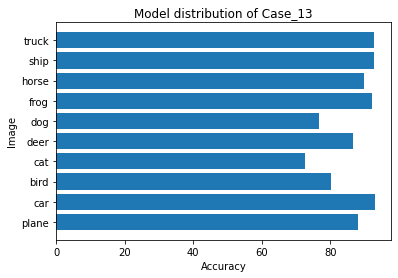

In [100]:
plot_dist(model, testloader, 'Case_13')

In [93]:
# un-normalize - https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
mean = std = [0.5, 0.5, 0.5]
inv_normalize = transforms.Normalize(
   mean=[-m/s for m, s in zip(mean, std)],
   std=[1/s for s in std]
)

def show_img(img):
    plt.imshow(inv_normalize(img).permute(1,2,0))
    plt.xticks([])
    plt.yticks([])
    
def plot_dist(res_dist):
    plt.bar(list(classes), res_dist)
    plt.xticks(rotation=90)

### Visualising probabilities of predictions
- Need to use `nn.Softmax` over predictions since our model outputs actual results (i.e. logits)

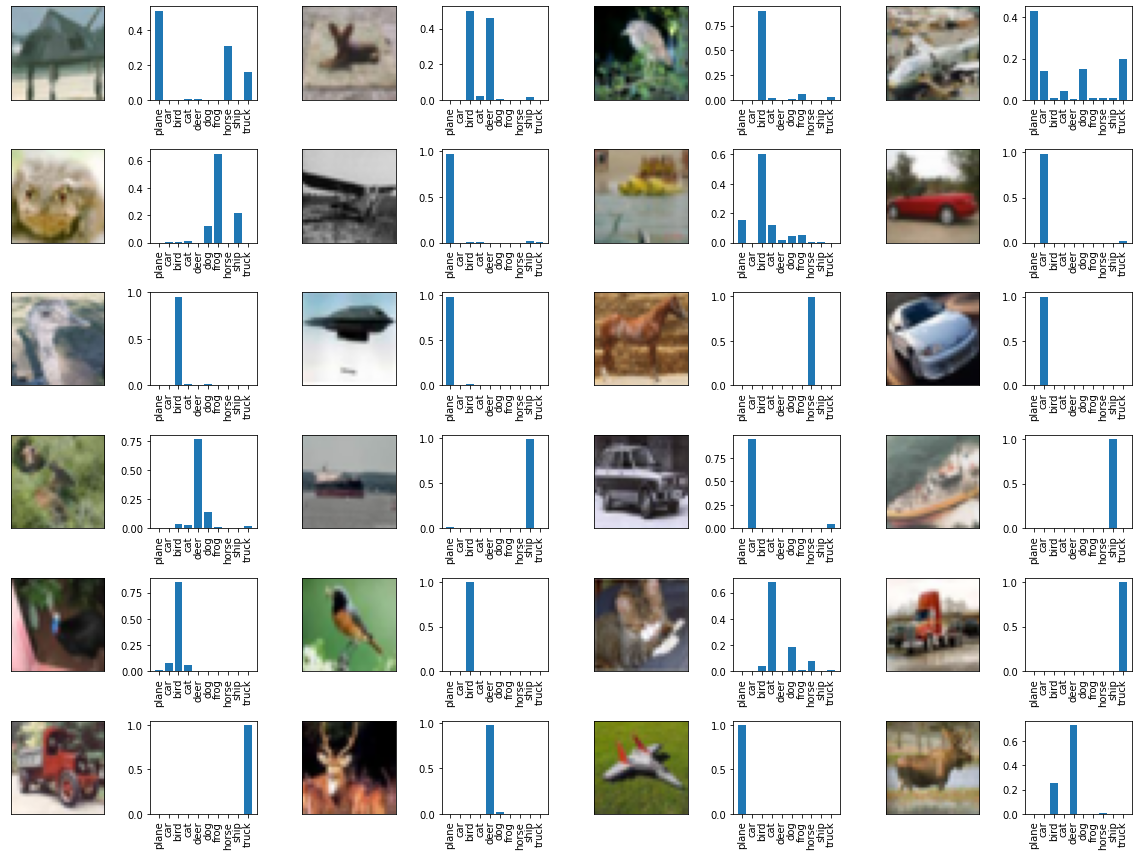

In [95]:
with torch.no_grad():
    img, lab = next(iter(testloader))
    img, lab = img.to(device), lab.to(device)
    res = nn.Softmax(dim=1)(model(img))

num_rows = 6
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    show_img(img[i].to('cpu'))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_dist(res[i].to('cpu'))
plt.tight_layout()
plt.show()

## Saving your model
Using `torch.save`, save your model for future loading.

In [77]:
torch.save(model.state_dict(), 'case_13d' + '.pth')

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).